## Simulation-based inference in the indo-pacific region

Here we provide usage examples of the `seismo-sbi` package. We utilise the real event data as well as real noise examples to build a realistic empirical model of the likelihood function. This notebook has two sections:

 - First, we run a fixed location moment tensor inversion, and compare the SBI results with a Gaussian likelihood solution.
 - Second, we run the full 10-parameter joint moment tensor and centroid source time-location inversion using SBI.

_Note: these results differ substantially from the paper since only local permanent land stations are used for the inversions_

Workflow:

![sbi_workflow](../assets/imgs/sbi_diagram.png)

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# prevent processes from using multiple threads
# this is necessary because otherwise the multiprocessing
# in emcee may use more threads than requested
import os
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["VECLIB_MAXIMUM_THREADS"] = "1"

In [3]:
import numpy as np

from seismo_sbi.sbi.configuration import SBI_Configuration
from seismo_sbi.sbi.pipeline import SingleEventPipeline, SBIPipelinePlotter

### Preparation for inversions

I have already downloaded and processed 3 weeks of data between 01.09.2024 - 20.09.2024 for a range of stations in the indo-pacific region.

See [here](https://ds.iris.edu/ieb/index.html?format=text&nodata=404&starttime=2024-09-01&endtime=2024-09-21&minmag=4.8&maxmag=10&orderby=time-desc&src=iris&limit=1000&maxlat=38.76&minlat=-23.64&maxlon=177.95&minlon=69.40&zm=4&mt=ter) for a map of relevant events. I have pre-processed a range of these as well. 

In [8]:
config = SBI_Configuration()

# specifying output filepaths, etc. 

main_config_options = dict(
    run_name='indo_pacific',
    output_directory= '.',
    job_name='fixed_location_inversion_talaud',
    generate_dataset= True,
    num_jobs= 10 # number of cores to utilise for all tasks
)

config.parse_main_options(main_config_options)

sbi_pipeline = SingleEventPipeline(config.pipeline_parameters)


### Section 1: Fixed Location Source Inversion

This section performs a fixed location event inversion. 

In [10]:
# forward modelling and processing options

simulation_config_options = dict(
    components= 'ZEN',
    stations_path= '../scripts/configs/indo_pacific/stations.txt',
    station_components_path= '../scripts/configs/indo_pacific/components_talaud2.json',
    seismogram_duration= 1740,
    sampling_rate= 0.5,
    syngine_address= "/data/shared/prem_a_20s", # if no local version, can use "syngine://prem_i_2s"
    processing=dict(
        filter=dict(
            type= 'bandpass',
            freqmin= 0.01,
            freqmax= 0.02,
            corners= 4,
            zerophase= False),
        sampling_rate=0.5
    ),
    
)

# initial parameters configurations

seismic_source_config=dict(
  inference=dict(
    moment_tensor=dict(
      #         [Mrr, Mtt, Mpp, Mrt, Mrp, Mtp]
      fiducial= [1.e+15, 1.e+15, 1.e+15, 1.e+15, 1.e+15, 1.e+15],
      stencil_deltas= [1.e+10, 1.e+10, 1.e+10, 1.e+10, 1.e+10, 1.e+10],
      bounds= [[-5.e+16, -5.e+16, -5.e+16, -5.e+16, -5.e+16, -5.e+16],
              [5.e+16, 5.e+16, 5.e+16, 5.e+16, 5.e+16, 5.e+16]]
        ),
    ),
  nuisance=dict( # we fix the source location here
    source_location=dict(
      #         [lat, long, depth, time]
      fiducial= [ 4.5327, 126.5069, 70.4, 0],
      bounds= [ 4.5327, 126.5069, 70.4, 0]
        )
    )
)

# dataset generation parameters

dataset_config_options = dict(
    num_simulations= 1000,
    sampling_method= dict(
        moment_tensor= 'uniform',
        source_location='constant'),
   use_fisher_to_constrain_bounds = 15,
)

config.parse_seismic_context(simulation_config_options)
config.parse_parameters(seismic_source_config)
config.parse_simulations_options(dataset_config_options)

sbi_pipeline.load_seismo_parameters(config.sim_parameters, config.model_parameters, config.dataset_parameters)

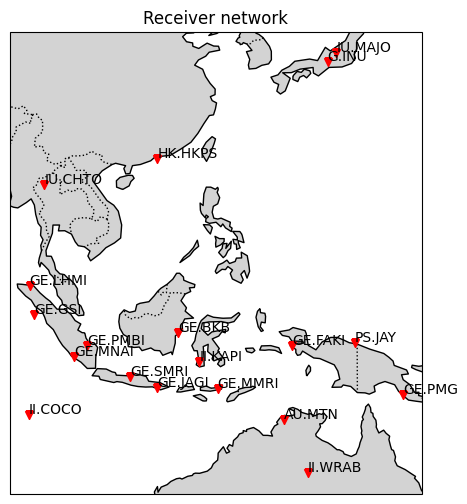

In [11]:
sbi_pipeline.simulation_parameters.receivers.plot()

### Real noise and event configuration

I have pre-processed a database of real noise, found under `/data/alex/noise/indo_pacific/long_period_samples`. These are concurrent 30 minute samples of noise across the station array over the period we are studying. 

There is also a range of events, $>M_W \: 5$, found under `/data/alex/indo_pacific/events_0.5hz`. These have also been preprocessed to a fixed length and sampling rate.

In [12]:
job_data_configuration = dict(  
    real_events=dict( # specify path to the real event data
        talaud_fixed= '/data/alex/indo_pacific/events_0.5hz/TALAUD_ISLANDS_INDONESIA_20240913_063349_Lat4.5327_Lon126.5069_event_filtered_0.5hz.h5'
    ),
    simulations=dict( # we don't run any artificial events here
        random_events= 0,
        fixed_events= [],
        custom_events= {},
    ),
    noise_models=dict(
        real_noise= '/data/alex/noise/indo_pacific/long_period_samples'
    ),
    plots=dict(
        async_plotting= True,
        test_posteriors= dict(
            chain_consumer= 
                [[['optimal_score', 'real_noise'], ['gaussian_likelihood', 'real_noise']]]
        ),
        disable_plotting= False
    )
)

config.parse_jobs_config(job_data_configuration)

In [13]:
# test_jobs_paths = sbi_pipeline.simulate_test_jobs(config.dataset_parameters, config.test_job_simulations)
sbi_pipeline.compute_data_vector_properties([], config.real_event_jobs)

In [14]:
compression_config = {'optimal_score':
    {'empirical_block':  '/data/alex/noise/indo_pacific/long_period_samples'}
}
config.parse_compression_options(compression_config)

score_compression_data, _ = sbi_pipeline.compute_required_compression_data(
    config.compression_methods,
    config.model_parameters,  
)

sbi_pipeline.load_compressors(config.compression_methods, score_compression_data)


Found 2428 noise realisations.


In [15]:
inference_options = dict(
  sbi=dict(
    method= 'posterior',
    noise_model= dict(
      type= 'real_noise',
      noise_catalogue_path= '/data/alex/noise/indo_pacific/long_period_samples',
      noise_level= 3.e-6,
    ),
  ),
  likelihood= dict(
    run= True, # we wish to run a likelihood inversion
    ensemble= False,
    covariance= 'empirical',
    num_samples= 20000,
    walker_burn_in= 2000,
    move_size= 0.0005,
  ),
)
config.parse_sbi_config(inference_options)

sbi_pipeline.load_test_noises(config.sbi_noise_model, config.test_noise_models)

Found 2428 noise realisations.
Found 2428 noise realisations.


In [16]:
# now load the relevant event
job_data = sbi_pipeline.create_job_data([], config.real_event_jobs)

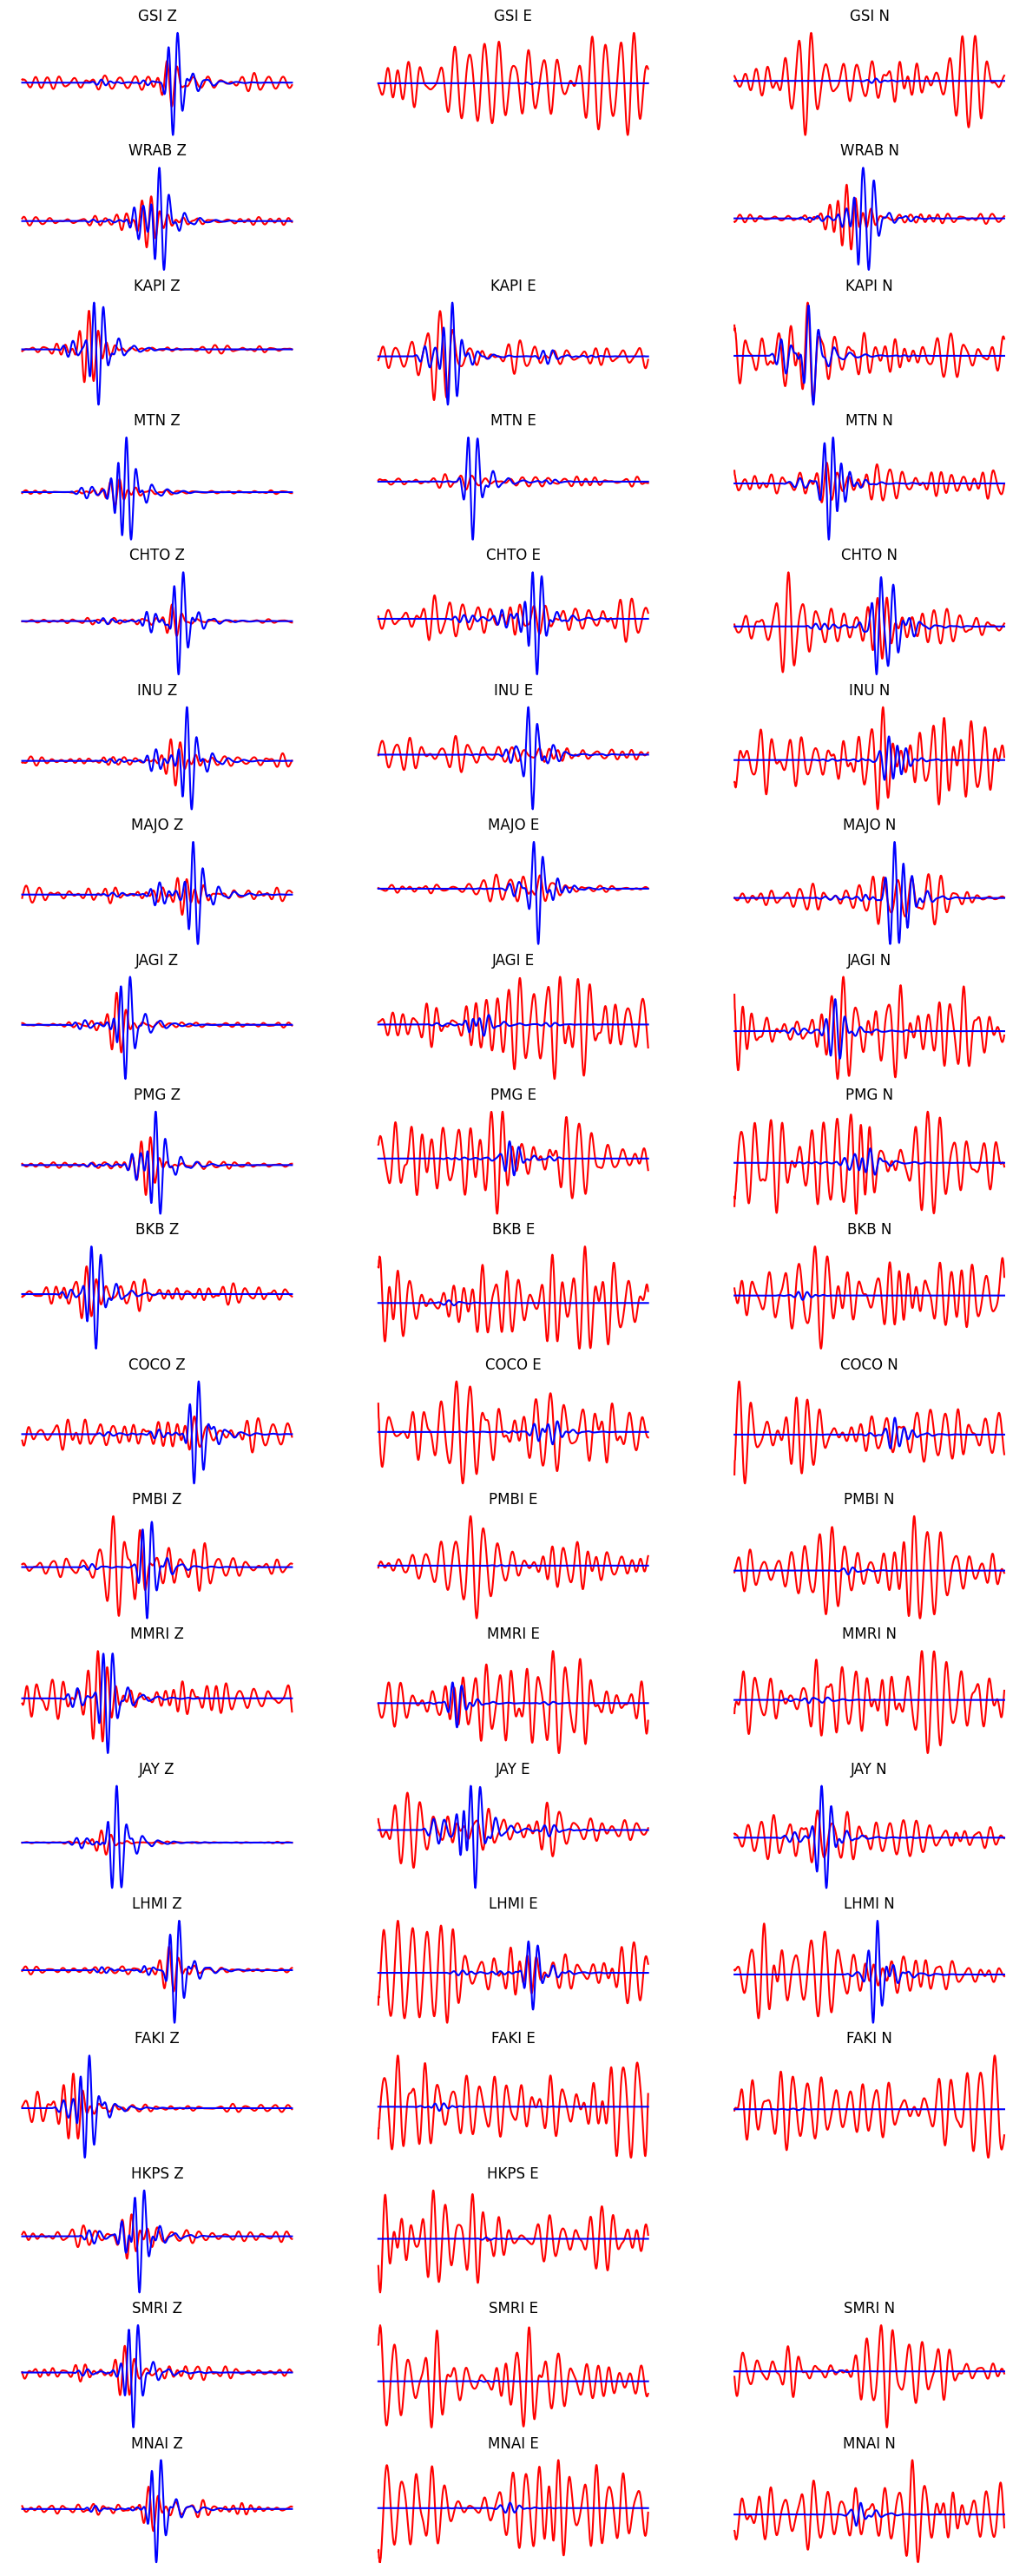

In [17]:
# let's plot the event + the GCMT solutions

gcmt_mt_solution  = np.array([-0.741, -0.351 , 1.092, -0.020, -2.047,  2.948]) * 1.e16
gcmt_synthetics = sbi_pipeline.simulator_wrapper.simulation_callable(gcmt_mt_solution)

plotter = SBIPipelinePlotter('', sbi_pipeline.parameters)
plotter.plot_synthetic_misfits(
    job_data[0], 
    sbi_pipeline.simulation_parameters.receivers, 
    gcmt_synthetics, 
    event_location= (4.5327, 126.5069),
    only_raw=True,
    savefig=False )


### Prepare for inversions

We now move parameter dictionaries into vector forms to prepare for inversions. Certain inversion configurations also update how we do the dataset generation stage, but we don't use that here.

In [18]:
dataset_details = config.dataset_parameters
param_names = sbi_pipeline.parameters.names

sim_name, test_noise, D, theta0_dict, covariance, priors = job_data[0]
sbi_pipeline.training_noise_sampler.set_adaptive_covariance_with_misc_data(covariance)
theta0, _  = sbi_pipeline.compute_theta0_and_update_dataset(param_names, dataset_details, theta0_dict)

### Find expansion point $\mathbf{m}_*$

We can compute the maximum-likelihood estimate of the model parameters $\mathbf{m}_*$ using some form of least squares minimisation.

Since this first inversion is a moment tensor inversion, this is linear and therefore solved in one step of least squares. 

In [19]:
compression_data = sbi_pipeline.find_mle_and_set_compressor(D, covariance, priors, dataset_details)

Performing iterative least squares for MLE fiducial:   0%|          | 0/1 [00:00<?, ?it/s]

chi^2: 1.65383, damping lambda: 0.000
New MLE:
moment_tensor: [6.737e+14, 4.014e+15, 1.149e+16, -1.014e+15, 2.271e+15, 5.139e+15]


Performing iterative least squares for MLE fiducial: 100%|██████████| 1/1 [00:06<00:00,  6.13s/it]


Constrain the prior according around the best model parameters using the Fisher information.

In [20]:
from seismo_sbi.sbi.scalers import FlexibleScaler
from seismo_sbi.sbi.inference import SBI_Inference
import torch

sbi_pipeline.use_kernel_simulator_if_possible(compression_data, dataset_details.sampling_method)

if dataset_details.use_fisher_to_constrain_bounds:
    dataset_details = sbi_pipeline.use_fisher_to_constrain_bounds(dataset_details, compression_data)

compressor = sbi_pipeline.compressors['optimal_score']
x_0 = compression_data.theta_fiducial

print('MLE', x_0)
print('bounds', sbi_pipeline.parameters.bounds)


MLE [ 6.73697896e+14  4.01416105e+15  1.14945770e+16 -1.01444667e+15
  2.27117736e+15  5.13894561e+15]
bounds {'moment_tensor': array([[-1.49493716e+15,  1.35819165e+14,  6.71570934e+15,
        -1.46570190e+15,  1.75954662e+15,  2.71792285e+15],
       [ 2.84233295e+15,  7.89250295e+15,  1.62734447e+16,
        -5.63191435e+14,  2.78280811e+15,  7.55996837e+15]]), 'source_location': [4.5327, 126.5069, 70.4, 0]}


Build a dataset of simulations from the constrained prior, before compressing the dataset and preprocessing it in preparation for the training stage. 

In [21]:

sbi_pipeline.ground_truth_scaler = FlexibleScaler(sbi_pipeline.parameters)
statistic_scaler = sbi_pipeline.ground_truth_scaler
x_0_scaled = statistic_scaler.transform(x_0.reshape(1,-1)).reshape(-1)

dataset = sbi_pipeline.generate_simulation_data(dataset_details, priors=priors)
raw_compressed_dataset = sbi_pipeline.data_manager.compress_dataset(
    compressor, param_names, sbi_pipeline.simulations_output_path, sbi_pipeline.training_noise_sampler
)
dataset.clear_all_outputs()

train_data = torch.Tensor(sbi_pipeline.scale_dataset(raw_compressed_dataset, sbi_pipeline.ground_truth_scaler, statistic_scaler))
train_data, raw_compressed_dataset = sbi_pipeline.clean_train_data(train_data, raw_compressed_dataset)

Compressing dataset: 100%|██████████| 1000/1000 [00:23<00:00, 41.81it/s]

Removed 46 rows due to high relative compression error.


Once the dataset has been prepared, we can proceed with the training stage. Here we use a pre-prepared architecture for modelling the probability density of the posterior distribution. 

Once trained, we can draw samples near-instantly from the trained neural density estimator.

In [22]:
from seismo_sbi.sbi.types.results import InversionResult, InversionData, InversionConfig

sbi_model = SBI_Inference('posterior', sbi_pipeline.num_dim)

sbi_model.build_amortised_estimator(train_data)

sample_results, _ = sbi_model.sample_posterior(x_0_scaled, num_samples=10000)

# package up the results
inversion_data = InversionData(None, sample_results, sbi_pipeline.ground_truth_scaler, compression_data)
inversion_result = InversionResult(sim_name, inversion_data, InversionConfig("", "real_noise", "optimal_score"))


 Neural network successfully converged after 36 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Quick sanity check: what does our best fitting solution look like compared to the observations?

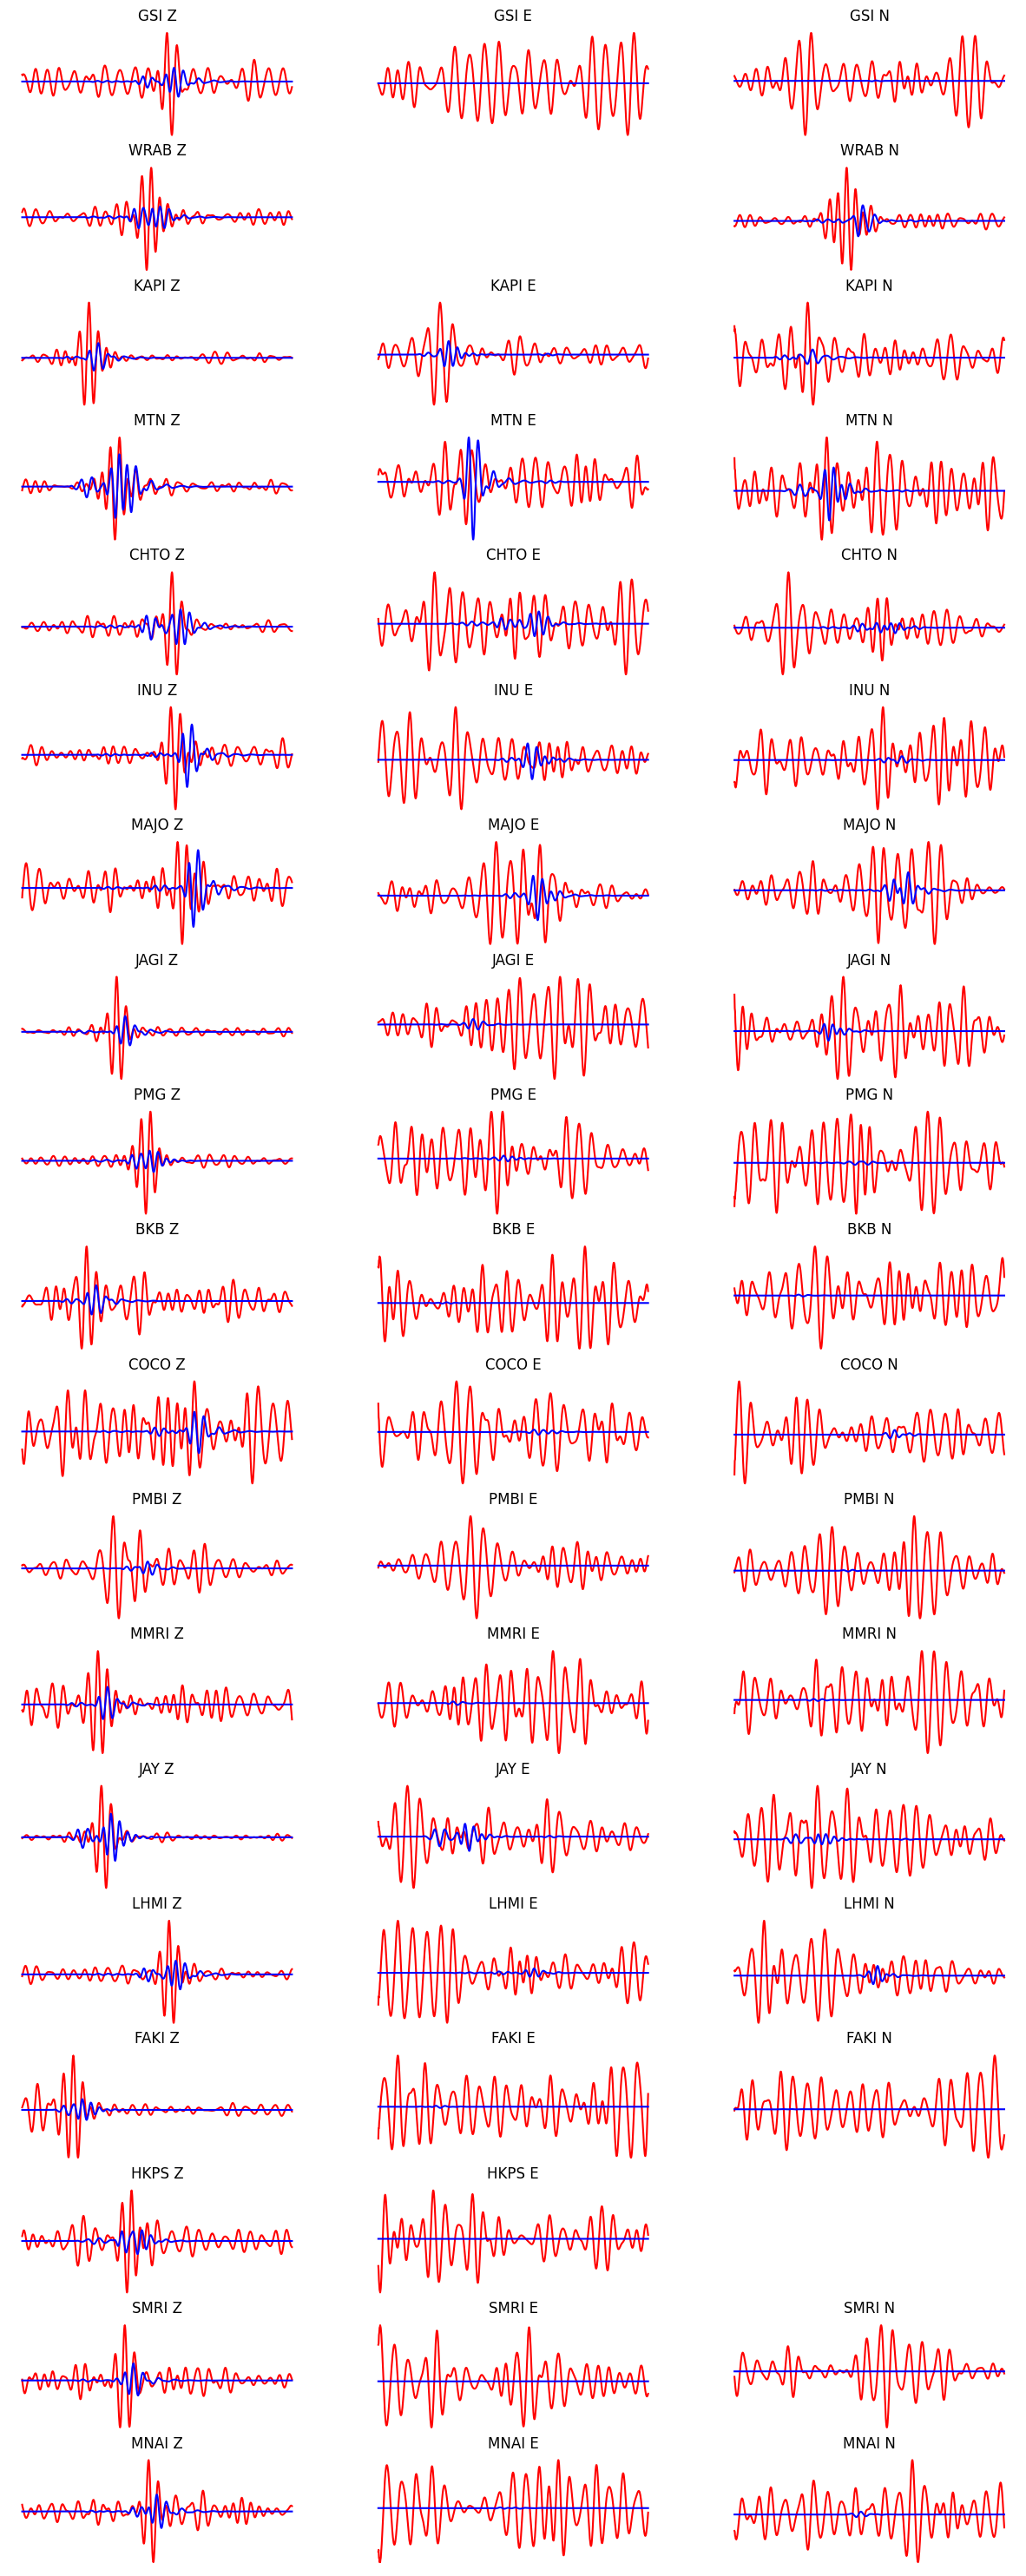

In [23]:
our_solution_MLE = compression_data.data_fiducial

plotter = SBIPipelinePlotter('', sbi_pipeline.parameters)
plotter.plot_synthetic_misfits(
    job_data[0], 
    sbi_pipeline.simulation_parameters.receivers, 
    our_solution_MLE, 
    event_location= (-4.1123, 142.9635),
    only_raw=True,
    savefig=False )


In [24]:
gl_result = next(sbi_pipeline.run_single_gaussian_likelihood_inversion(job_data[0], inference_options['likelihood'], sbi_pipeline.parameters, priors))

Running MCMC chains: 100%|██████████| 10/10 [03:14<00:00, 19.49s/it]


### Posterior Solutions

Finally, we can plot the resulting sample ensembles from the SBI approach (blue) vs. the Gaussian likelihood approach. 

Plotting posterior comparisons:   0%|          | 0/1 [00:00<?, ?it/s]

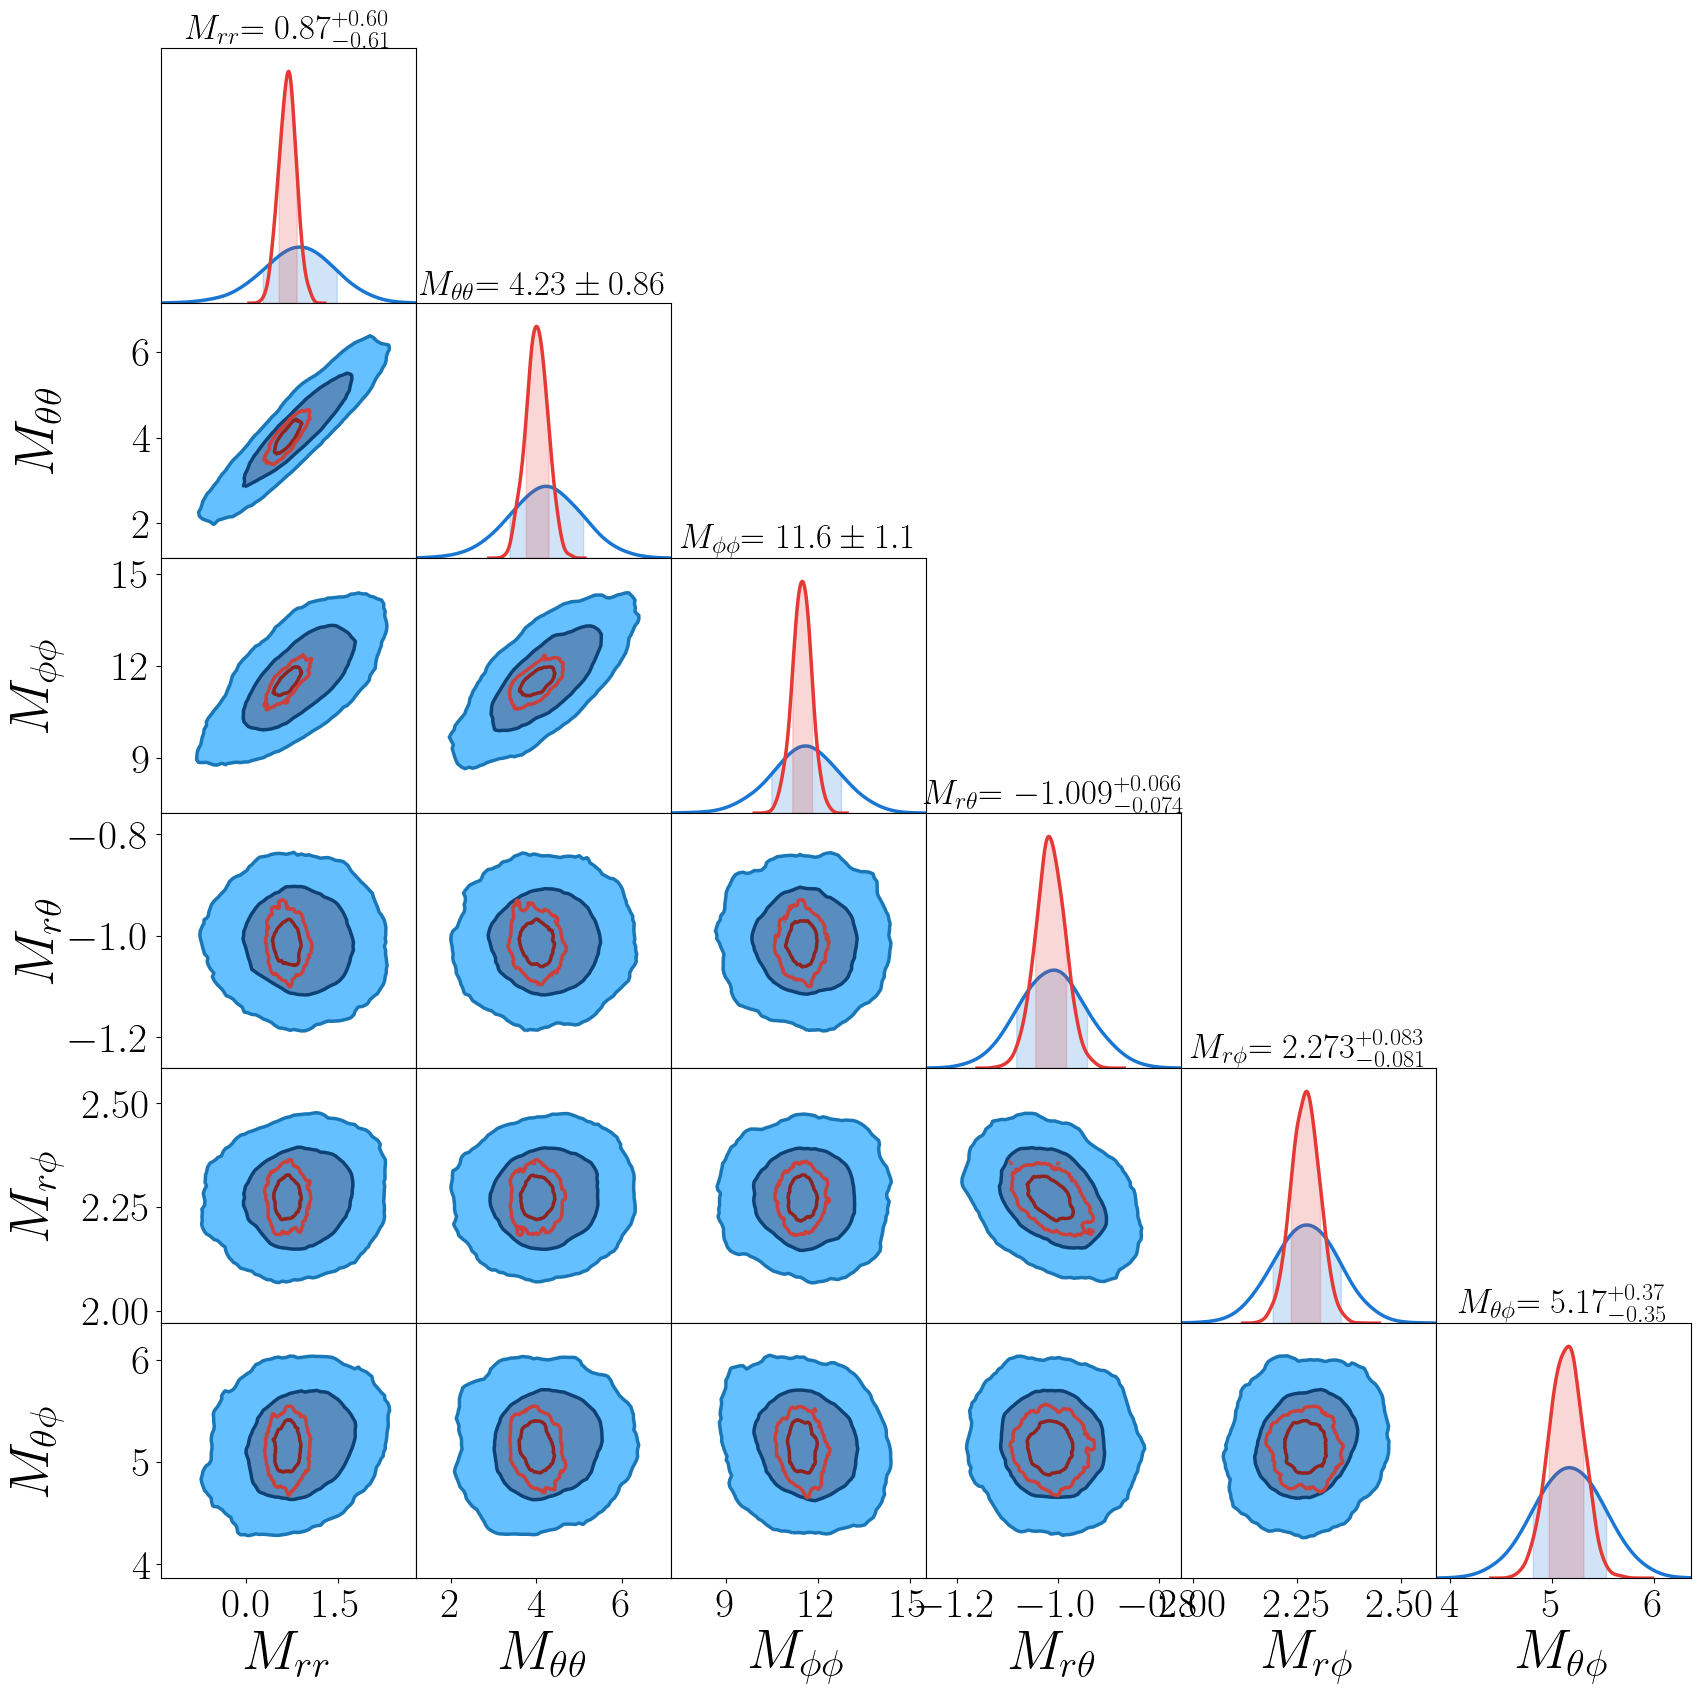

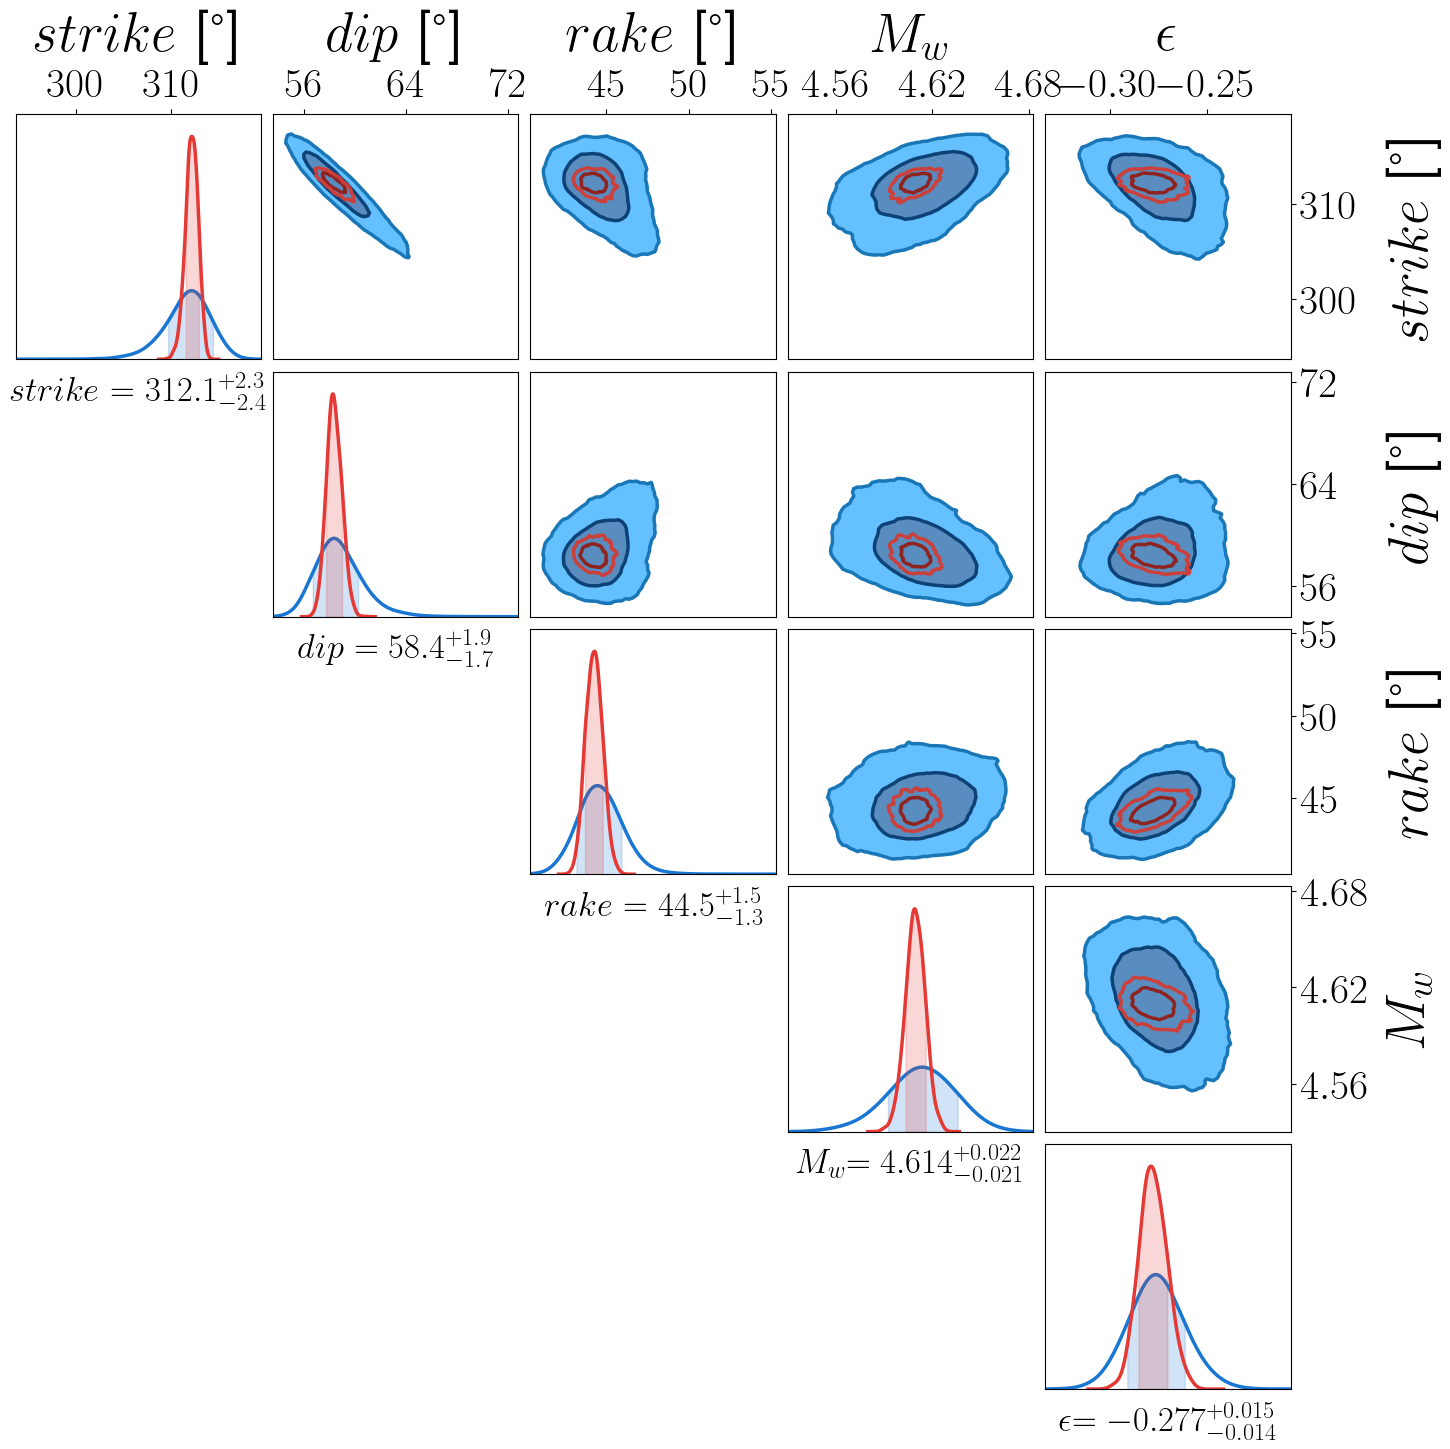

Plotting posterior comparisons: 100%|██████████| 1/1 [00:51<00:00, 51.51s/it]


In [25]:
inversion_results = [inversion_result, gl_result[1]]
sbi_pipeline.plot_comparisons(inversion_results, config.plotting_options['test_posteriors']['chain_consumer'], savefig=False)

### Section 2: Full source inversion with SBI

In [71]:
config = SBI_Configuration()
config.parse_main_options(main_config_options)

sbi_pipeline = SingleEventPipeline(config.pipeline_parameters)


seismic_source_config=dict(
  inference=dict(
    moment_tensor=dict(
      #         [Mrr, Mtt, Mpp, Mrt, Mrp, Mtp]
      fiducial= [1.e+15, 1.e+15, 1.e+15, 1.e+15, 1.e+15, 1.e+15],
      stencil_deltas= [1.e+10, 1.e+10, 1.e+10, 1.e+10, 1.e+10, 1.e+10],
      bounds= [[-5.e+16, -5.e+16, -5.e+16, -5.e+16, -5.e+16, -5.e+16],
              [5.e+16, 5.e+16, 5.e+16, 5.e+16, 5.e+16, 5.e+16]]
        ),
    source_location=dict(
      #         [lat, long, depth, time]
      fiducial= [4.5327, 126.5069 , 80, 0],
      stencil_deltas=[0.00001, 0.00001, 0.001, 0.001],
      bounds= [[4.5327, 126.5069, 8.5, -1],
              [4.5327, 126.5069, 24.5, 1]]
        )
    ),
  nuisance=dict()
)

# dataset generation parameters

dataset_config_options = dict(
    num_simulations= 2000,
    sampling_method= dict(
        moment_tensor= 'uniform',
        source_location='uniform'),
   use_fisher_to_constrain_bounds = 15,
   iterative_least_squares=dict(
      max_iterations=20,
      damping_factor=0.01,
   )
)

config.parse_sbi_config(inference_options)
config.parse_seismic_context(simulation_config_options)
config.parse_compression_options(compression_config)
config.parse_parameters(seismic_source_config)
config.parse_simulations_options(dataset_config_options)
config.parse_jobs_config(job_data_configuration)

sbi_pipeline.load_seismo_parameters(config.sim_parameters, config.model_parameters, config.dataset_parameters)

In [73]:
score_compression_data, _ = sbi_pipeline.compute_required_compression_data(
    config.compression_methods,
    config.model_parameters,  
)
sbi_pipeline.compute_data_vector_properties([], config.real_event_jobs)

sbi_pipeline.load_compressors(config.compression_methods, score_compression_data)


Found 2428 noise realisations.


In [74]:
inference_options = dict(
  sbi=dict(
    method= 'posterior',
    noise_model= dict(
      type= 'real_noise',
      noise_catalogue_path= '/data/alex/noise/indo_pacific/long_period_samples',
      noise_level= 3.e-6,
    ),
  ),
# turn off likelihood inversions - you can turn them on if you want to see the results,
# but it took ~ 30 minutes with a local instaseis model
  likelihood= dict( 
    run= False,
    ensemble= True,
    covariance= 'empirical',
    num_samples= 20000,
    walker_burn_in= 2000,
    move_size= 0.0005,
  ),
)
config.parse_sbi_config(inference_options)

sbi_pipeline.load_test_noises(config.sbi_noise_model, config.test_noise_models)

Found 2428 noise realisations.
Found 2428 noise realisations.


### Find expansion point $\mathbf{m}_*$

We can compute the maximum-likelihood estimate of the model parameters $\mathbf{m}_*$ using some form of least squares minimisation.

Since this second inversion is non-linear, we must perform an iterative least-squares procedure to converge on a local minimum. 

**NOTE: It's probably worth running with only a couple of least squares steps to remove bad stations**

![prior](../assets/imgs/prior_constraining_step.png)

In [75]:
dataset_details = config.dataset_parameters
param_names = sbi_pipeline.parameters.names

sim_name, test_noise, D, theta0_dict, covariance, priors = job_data[0]
sbi_pipeline.training_noise_sampler.set_adaptive_covariance_with_misc_data(covariance)
theta0, _  = sbi_pipeline.compute_theta0_and_update_dataset(param_names, dataset_details, theta0_dict)
compression_data = sbi_pipeline.find_mle_and_set_compressor(D, covariance, priors, dataset_details)

Performing iterative least squares for MLE fiducial:   0%|          | 0/20 [00:00<?, ?it/s]

chi^2: 1.64447, damping lambda: 0.007
New MLE:
moment_tensor: [6.814e+15, 1.451e+16, 1.092e+16, -6.338e+14, 2.279e+15, 1.729e+15]
source_location: [4.606, 127.236, 176.621, 8.944]


Performing iterative least squares for MLE fiducial:   5%|▌         | 1/20 [00:09<03:00,  9.51s/it]

chi^2: 1.65666, damping lambda: 0.008
New MLE:
moment_tensor: [1.155e+16, 1.405e+16, 8.028e+15, 1.808e+15, 2.569e+15, 6.634e+15]
source_location: [4.434, 127.027, 210.028, 8.342]


Performing iterative least squares for MLE fiducial:  10%|█         | 2/20 [00:20<03:04, 10.23s/it]

chi^2: 1.47289, damping lambda: 0.005
New MLE:
moment_tensor: [1.012e+16, 6.910e+15, 1.305e+16, -2.073e+14, 5.543e+15, 1.290e+16]
source_location: [4.282, 126.534, 190.281, 9.295]


Performing iterative least squares for MLE fiducial:  15%|█▌        | 3/20 [00:30<02:54, 10.26s/it]

chi^2: 1.55012, damping lambda: 0.006
New MLE:
moment_tensor: [1.587e+16, 1.746e+16, 8.194e+15, 2.773e+14, 6.223e+15, 3.541e+15]
source_location: [4.257, 126.992, 176.050, 9.743]


Performing iterative least squares for MLE fiducial:  20%|██        | 4/20 [00:41<02:47, 10.49s/it]

chi^2: 1.48808, damping lambda: 0.004
New MLE:
moment_tensor: [9.448e+15, 9.129e+15, 1.574e+16, -5.155e+14, 6.831e+15, 1.309e+16]
source_location: [4.263, 126.620, 185.557, 10.449]


Performing iterative least squares for MLE fiducial:  25%|██▌       | 5/20 [00:51<02:36, 10.45s/it]

chi^2: 1.56177, damping lambda: 0.005
New MLE:
moment_tensor: [1.703e+16, 1.774e+16, 8.895e+15, -6.345e+13, 6.902e+15, 4.205e+15]
source_location: [4.176, 126.883, 172.176, 9.397]


Performing iterative least squares for MLE fiducial:  30%|███       | 6/20 [01:01<02:25, 10.36s/it]

chi^2: 1.49473, damping lambda: 0.003
New MLE:
moment_tensor: [1.109e+16, 1.177e+16, 1.639e+16, -5.844e+14, 6.337e+15, 1.224e+16]
source_location: [4.286, 126.693, 174.696, 10.438]


Performing iterative least squares for MLE fiducial:  35%|███▌      | 7/20 [01:11<02:10, 10.06s/it]

chi^2: 1.51914, damping lambda: 0.004
New MLE:
moment_tensor: [1.676e+16, 1.727e+16, 9.397e+15, -6.390e+13, 6.517e+15, 5.437e+15]
source_location: [4.167, 126.883, 168.150, 8.884]


Performing iterative least squares for MLE fiducial:  40%|████      | 8/20 [01:21<02:00, 10.05s/it]

chi^2: 1.46704, damping lambda: 0.003
New MLE:
moment_tensor: [1.173e+16, 1.309e+16, 1.659e+16, -5.704e+14, 5.414e+15, 1.152e+16]
source_location: [4.292, 126.728, 161.966, 10.210]


Performing iterative least squares for MLE fiducial:  45%|████▌     | 9/20 [01:30<01:48,  9.88s/it]

chi^2: 1.49262, damping lambda: 0.003
New MLE:
moment_tensor: [1.671e+16, 1.752e+16, 1.007e+16, -3.395e+13, 6.044e+15, 5.506e+15]
source_location: [4.147, 126.902, 155.724, 8.513]


Performing iterative least squares for MLE fiducial:  50%|█████     | 10/20 [01:40<01:37,  9.72s/it]

chi^2: 1.45860, damping lambda: 0.002
New MLE:
moment_tensor: [1.330e+16, 1.582e+16, 1.785e+16, -6.407e+14, 4.463e+15, 1.005e+16]
source_location: [4.243, 126.761, 139.371, 9.801]


Performing iterative least squares for MLE fiducial:  55%|█████▌    | 11/20 [01:49<01:25,  9.50s/it]

chi^2: 1.45339, damping lambda: 0.003
New MLE:
moment_tensor: [1.623e+16, 1.864e+16, 1.114e+16, -1.638e+14, 5.001e+15, 5.482e+15]
source_location: [4.120, 126.914, 131.753, 8.167]


Performing iterative least squares for MLE fiducial:  60%|██████    | 12/20 [01:59<01:16,  9.57s/it]

chi^2: 1.42305, damping lambda: 0.002
New MLE:
moment_tensor: [1.414e+16, 1.846e+16, 1.585e+16, -6.629e+14, 3.120e+15, 6.810e+15]
source_location: [4.123, 126.864, 100.288, 9.060]


Performing iterative least squares for MLE fiducial:  65%|██████▌   | 13/20 [02:08<01:06,  9.55s/it]

chi^2: 1.37651, damping lambda: 0.001
New MLE:
moment_tensor: [1.017e+16, 1.480e+16, 7.076e+15, -4.332e+14, 3.240e+15, 6.329e+15]
source_location: [4.050, 126.969, 86.057, 8.230]


Performing iterative least squares for MLE fiducial:  70%|███████   | 14/20 [02:17<00:55,  9.33s/it]

chi^2: 1.36488, damping lambda: 0.001
New MLE:
moment_tensor: [9.356e+15, 1.395e+16, 7.659e+15, -4.855e+14, 3.146e+15, 6.988e+15]
source_location: [4.033, 126.930, 80.587, 8.777]


Performing iterative least squares for MLE fiducial:  75%|███████▌  | 15/20 [02:27<00:47,  9.47s/it]

chi^2: 1.36171, damping lambda: 0.002
New MLE:
moment_tensor: [9.355e+15, 1.392e+16, 7.143e+15, -4.883e+14, 3.139e+15, 6.903e+15]
source_location: [4.006, 126.945, 80.019, 8.956]


Performing iterative least squares for MLE fiducial:  80%|████████  | 16/20 [02:36<00:38,  9.52s/it]

chi^2: 1.36107, damping lambda: 0.002
New MLE:
moment_tensor: [9.291e+15, 1.380e+16, 7.138e+15, -4.866e+14, 3.138e+15, 7.021e+15]
source_location: [3.994, 126.944, 79.970, 9.254]


Performing iterative least squares for MLE fiducial:  85%|████████▌ | 17/20 [02:46<00:28,  9.46s/it]

chi^2: 1.36076, damping lambda: 0.002
New MLE:
moment_tensor: [9.360e+15, 1.387e+16, 6.924e+15, -4.793e+14, 3.117e+15, 7.064e+15]
source_location: [3.982, 126.950, 80.099, 9.453]


Performing iterative least squares for MLE fiducial:  90%|█████████ | 18/20 [02:55<00:19,  9.57s/it]

chi^2: 1.36055, damping lambda: 0.003
New MLE:
moment_tensor: [9.495e+15, 1.396e+16, 6.912e+15, -4.704e+14, 3.103e+15, 7.145e+15]
source_location: [3.976, 126.953, 80.695, 9.653]


Performing iterative least squares for MLE fiducial:  95%|█████████▌| 19/20 [03:05<00:09,  9.64s/it]

chi^2: 1.36038, damping lambda: 0.003
New MLE:
moment_tensor: [9.622e+15, 1.408e+16, 6.820e+15, -4.599e+14, 3.083e+15, 7.210e+15]
source_location: [3.970, 126.958, 81.170, 9.820]


Performing iterative least squares for MLE fiducial: 100%|██████████| 20/20 [03:15<00:00,  9.76s/it]


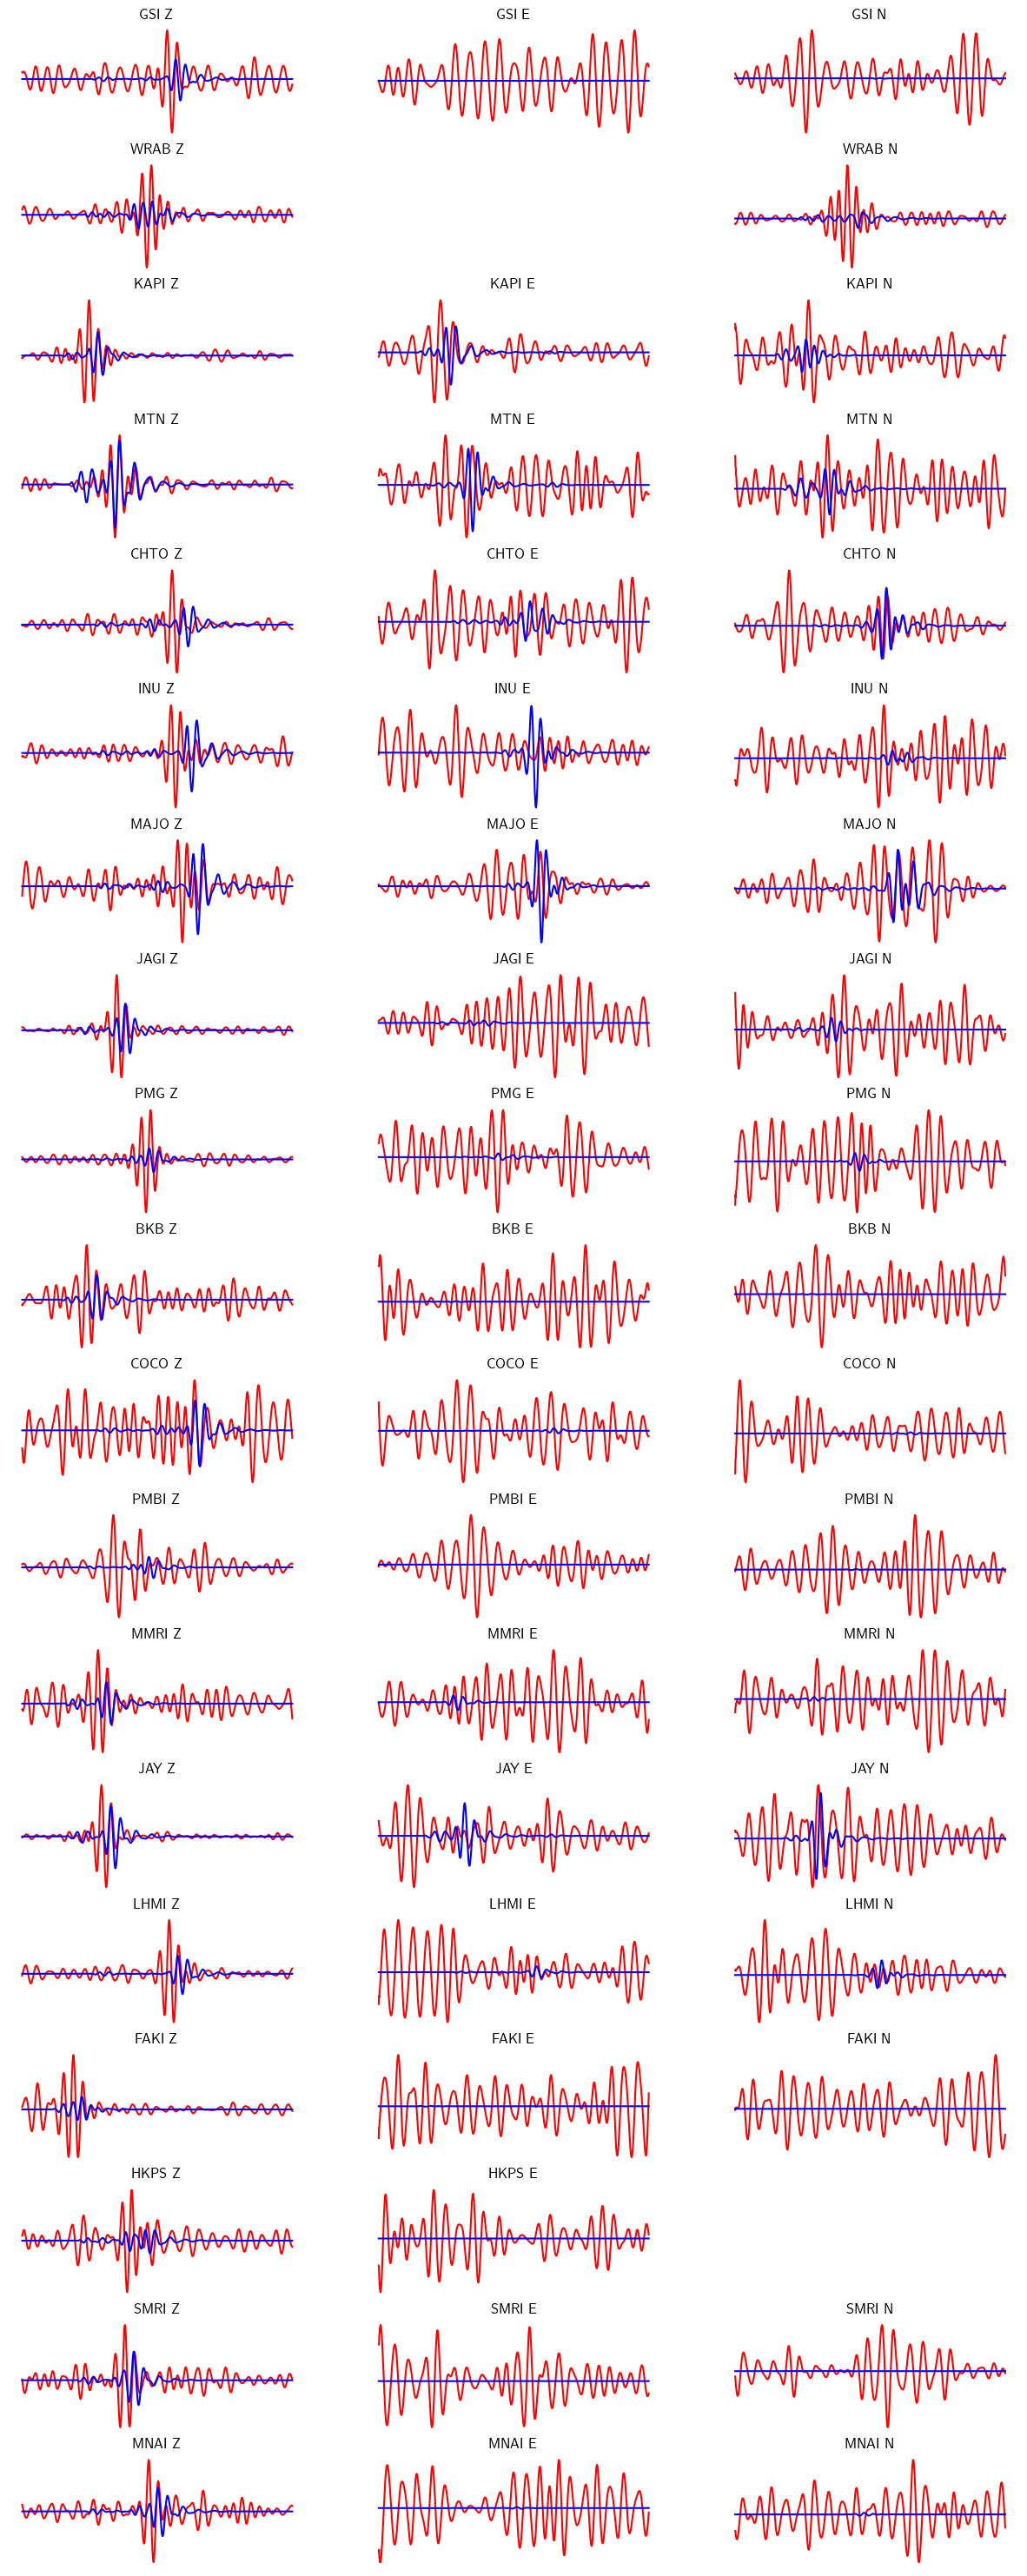

In [81]:
our_solution_MLE = compression_data.data_fiducial

plotter = SBIPipelinePlotter('', sbi_pipeline.parameters)
plotter.plot_synthetic_misfits(
    job_data[0], 
    sbi_pipeline.simulation_parameters.receivers, 
    our_solution_MLE, 
    event_location= (-4.1123, 142.9635),
    only_raw=True,
    savefig=False )

In [76]:
from seismo_sbi.sbi.scalers import FlexibleScaler
from seismo_sbi.sbi.inference import SBI_Inference
import torch

sbi_pipeline.use_kernel_simulator_if_possible(compression_data, dataset_details.sampling_method)

if dataset_details.use_fisher_to_constrain_bounds:
    dataset_details = sbi_pipeline.use_fisher_to_constrain_bounds(dataset_details, compression_data)

compressor = sbi_pipeline.compressors['optimal_score']
x_0 = compression_data.theta_fiducial

print('MLE', x_0)
print('bounds', sbi_pipeline.parameters.bounds)

MLE [ 9.62152520e+15  1.40845983e+16  6.81982531e+15 -4.59934384e+14
  3.08259253e+15  7.21002324e+15  3.96992173e+00  1.26957922e+02
  8.11699639e+01  9.82016284e+00]
bounds {'moment_tensor': array([[ 4.52792373e+15,  8.18376649e+15, -3.47221407e+14,
        -9.46808848e+14,  2.48674021e+15,  4.67164740e+15],
       [ 1.47151267e+16,  1.99854301e+16,  1.39868720e+16,
         2.69400789e+13,  3.67844486e+15,  9.74839908e+15]]), 'source_location': array([[  3.86838731, 126.85304108,  63.91408043,   8.21349316],
       [  4.07145614, 127.06280205,  98.42584742,  11.42683251]])}


In [77]:

sbi_pipeline.ground_truth_scaler = FlexibleScaler(sbi_pipeline.parameters)
statistic_scaler = sbi_pipeline.ground_truth_scaler
x_0_scaled = statistic_scaler.transform(x_0.reshape(1,-1)).reshape(-1)

dataset = sbi_pipeline.generate_simulation_data(dataset_details, priors=priors)
raw_compressed_dataset = sbi_pipeline.data_manager.compress_dataset(
    compressor, param_names, sbi_pipeline.simulations_output_path, sbi_pipeline.training_noise_sampler
)
dataset.clear_all_outputs()

train_data = torch.Tensor(sbi_pipeline.scale_dataset(raw_compressed_dataset, sbi_pipeline.ground_truth_scaler, statistic_scaler))
train_data, raw_compressed_dataset = sbi_pipeline.clean_train_data(train_data, raw_compressed_dataset)

Compressing dataset: 100%|██████████| 2000/2000 [00:47<00:00, 42.35it/s]


Removed 134 rows due to high relative compression error.


In [78]:
from seismo_sbi.sbi.types.results import InversionResult, InversionData, InversionConfig

sbi_model = SBI_Inference('posterior', sbi_pipeline.num_dim)

sbi_model.build_amortised_estimator(train_data)

sample_results, _ = sbi_model.sample_posterior(x_0_scaled, num_samples=10000)

# package up the results
inversion_data = InversionData(None, sample_results, sbi_pipeline.ground_truth_scaler, compression_data)
inversion_result = InversionResult(sim_name, inversion_data, InversionConfig("", "real_noise", "optimal_score"))


 Training neural network. Epochs trained: 79

Plotting posterior comparisons:   0%|          | 0/1 [35:24<?, ?it/s]


 Neural network successfully converged after 116 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

In [79]:
inversion_results = [inversion_result]
inversion_data = inversion_results[0].inversion_data
plotter = SBIPipelinePlotter("", sbi_pipeline.parameters)
flattened_param_info = sbi_pipeline.parameters.parameter_to_vector('information')
plotter.initialise_posterior_plotter(inversion_data.data_scaler, flattened_param_info)

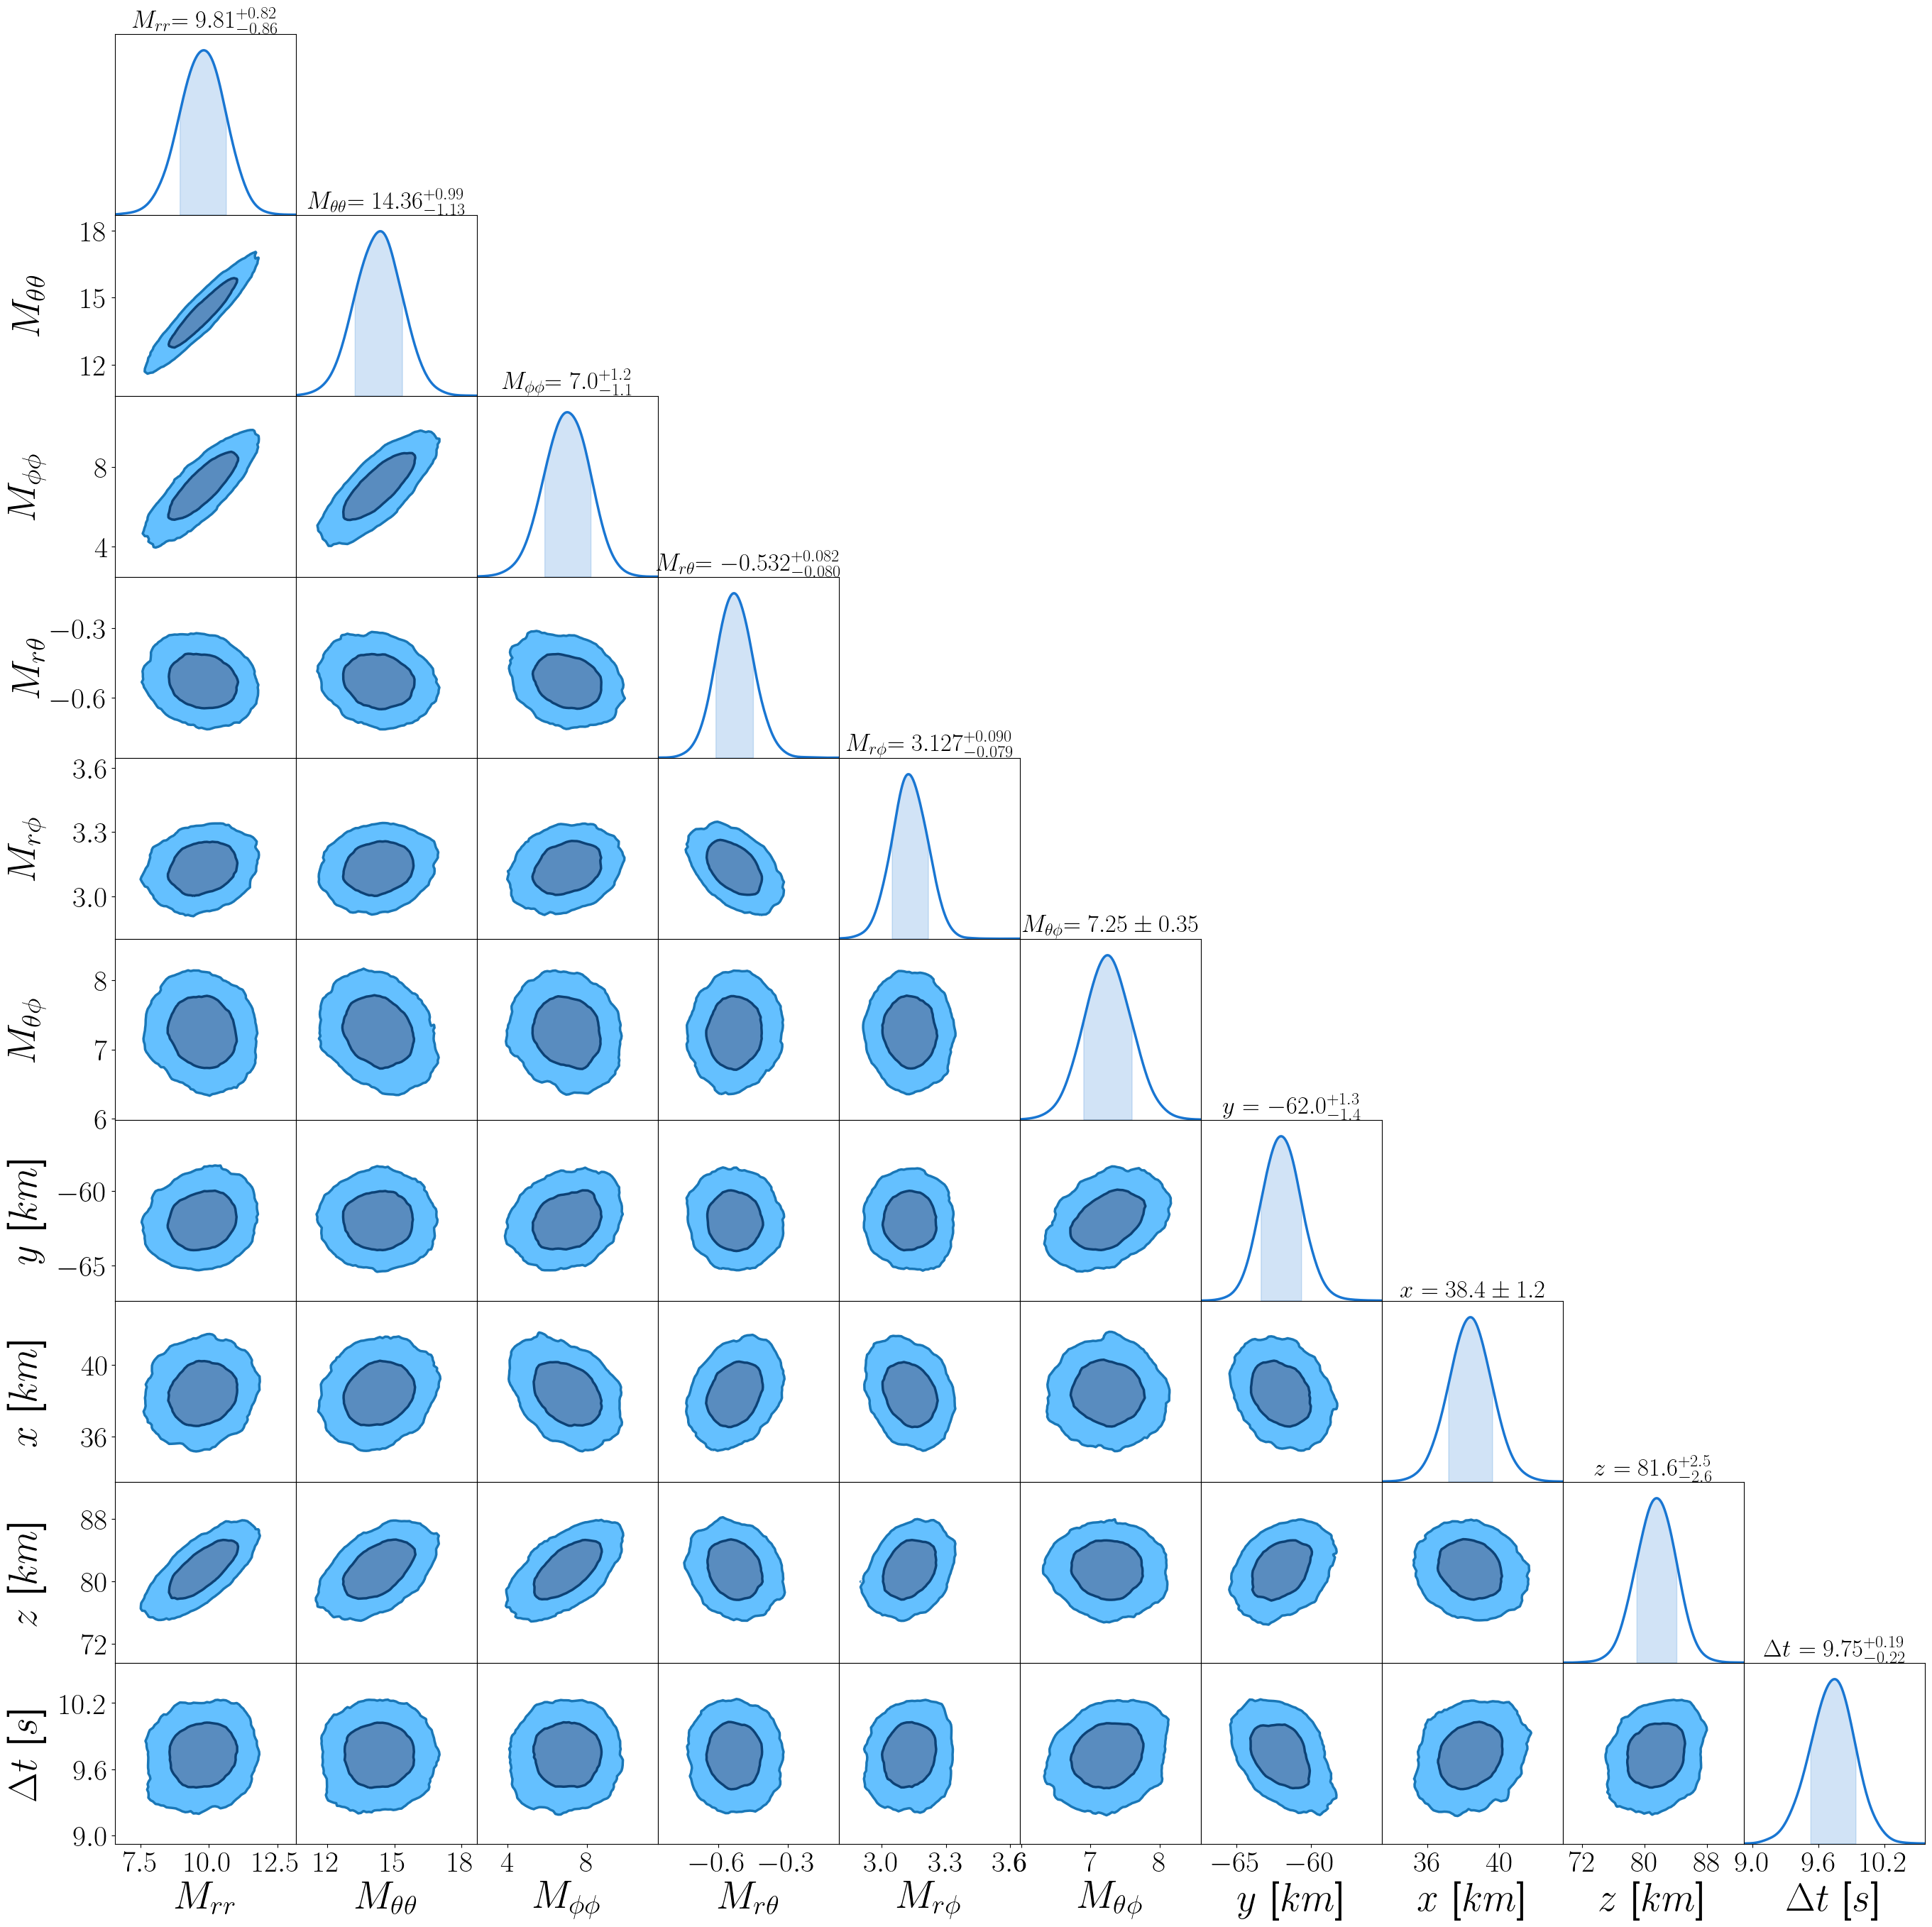

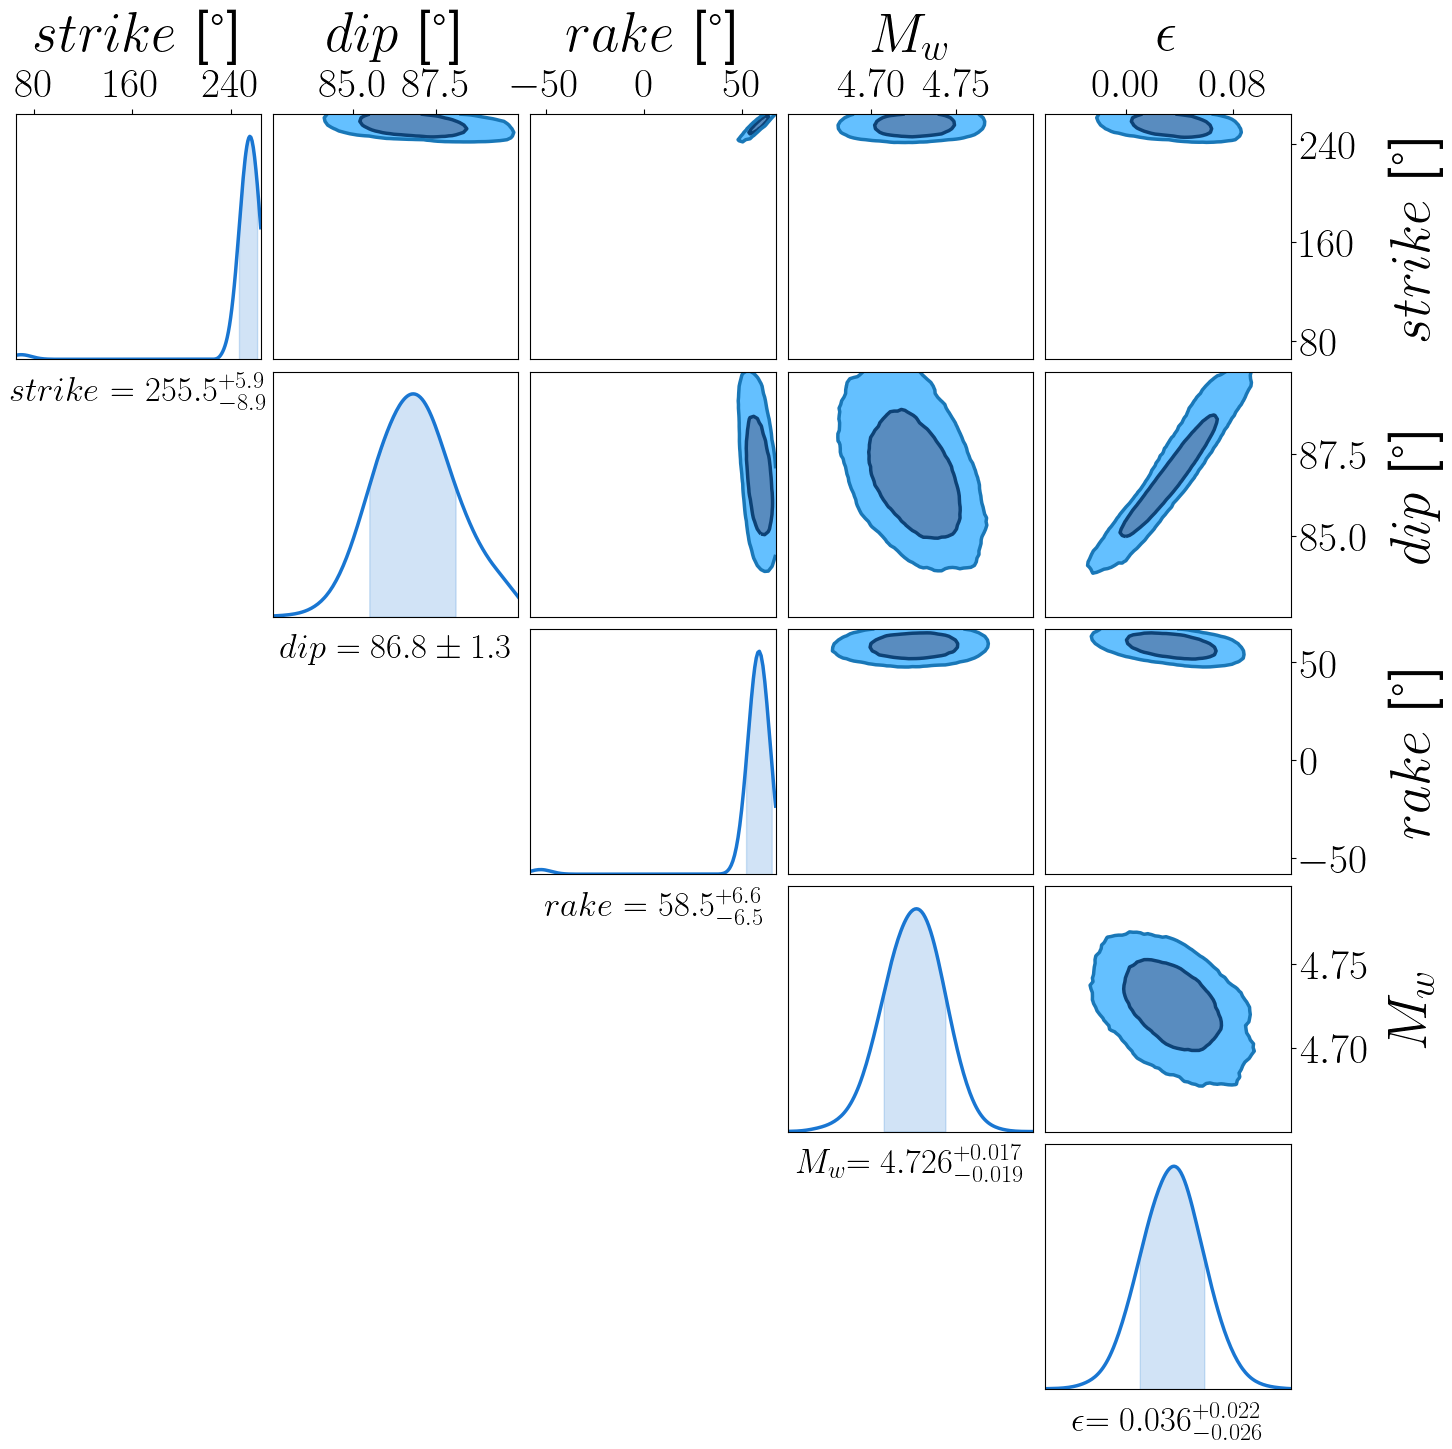

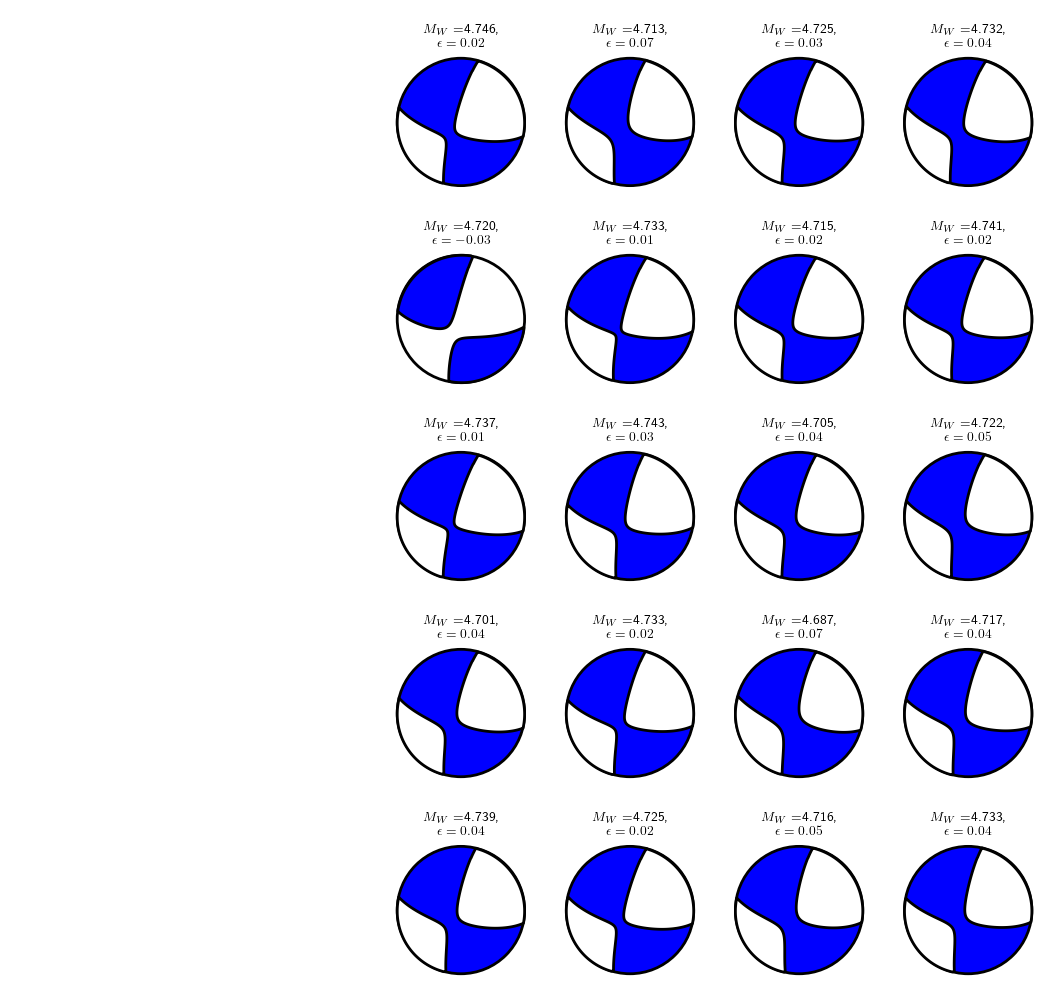

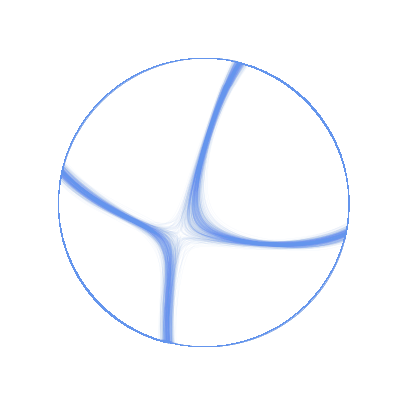

In [80]:
plotter.plot_posterior('sbi', inversion_data, kde=True, savefig=False)